# Transfer Learning on Images with Tensorflow

This demo will demonstrate how to do transfer learning to leverage the power of a deep convolutional neural network without having to train one yourself. Most people do not train those types of networks from scratch because of the large data and computational power requirements. What is more common is to train the network on a large dataset (unrelated to our task) and then leverage the representation it learnt in one of the following ways:

- as the initialization of a new network which will then be trained on our specific task (fine tuning)
- as a feature generator, essentially passing in our examples in the network so it can embed them in the abstract representation it learnt

This notebook will be doing the latter using the [Inception-v3 model](http://arxiv.org/abs/1512.00567) that was trained on the [ImageNet](http://image-net.org) Large Visual Recognition Challenge dataset made up of over 1 million images, where the task was to classify images into 1000 classes.

We will cover three topics in this demo:

- [Unsupervised learning](#unsupervised): using the image embedding as input in a dimensionality reduction algorithm for visualization
- [Supervised learning](#supervised): using the image embedding as features for a multi-class classification task
- [The *Dataset Builder* plugin](#datasetBuilder): showing a plugin that uses the techniques introduced to build a binary image classifier by doing similarity search through a web UI

You can see the *Dataset Builder* plugin in action in this short video:<a name="video"></a>


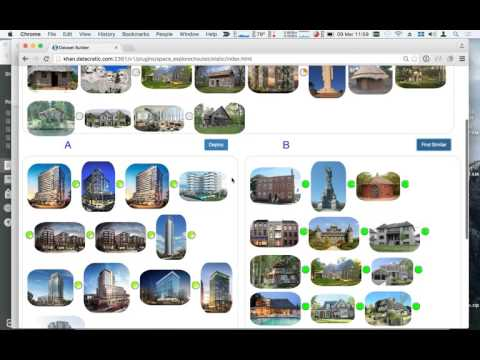

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("TZX1vf3lewI")

We recommend reading the [Tensorflow Image Recognition Tutorial](../../../../doc/nblink.html#_tutorials/Tensorflow Image Recognition Tutorial) before going though this demo.

## Initializing pymldb and other imports

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](../../../../doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](../../../../doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [2]:
from pymldb import Connection
mldb = Connection()
import urllib2, pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib._png import read_png
%matplotlib inline

## The dataset

In the [Tensorflow Image Recognition Tutorial](../../../../doc/nblink.html#_tutorials/Tensorflow Image Recognition Tutorial) tutorial, you saw how to embed the image of Admiral Grace Hopper using the *Inception* model. To embed a whole dataset of images, we do the same thing but within a procedure of type `transform`. We will not cover this in details in the notebook, but the detailed code is available in the [*Dataset Builder* plugin's code](https://github.com/mldbai/dataset-builder/blob/master/routes.py#L317).

We ship the plugin with 4 pre-assembled datasets: real-estate, recipes, transportation and pets. We start by loading the embeddings of the images for the real-estate dataset:

In [3]:
prefix = "http://public.mldb.ai/datasets/dataset-builder"

print mldb.put("/v1/procedures/embedded_images", {
    "type": "import.text",
    "params": {
        "dataFileUrl": prefix + "/cache/dataset_creator_embedding_realestate.csv.gz",
        "outputDataset": {
                "id": "embedded_images_realestate",
                "type": "embedding"
            },
        "select": "* EXCLUDING(rowName)",
        "named": "rowName",
        "runOnCreation": True
    }
})

<Response [201]>


The dataset we just imported has one row per image and the dense columns are the 2048-dimensional embeddings. We used the second to last layer of the network, the `pool_3` layer, which is less specialized than the final `softmax` layer of the network. Since the *Inception* model was trained on the ImageNet task, the last layer has been trained to perform very well on that specific task, while the previous layers are more abstract representations and are more suitable for transfer learning tasks.

The following query shows the embedding values for 2 rows:

In [4]:
mldb.query("SELECT * FROM embedded_images_realestate ORDER BY rowHash() ASC LIMIT 5")

,"""pool_3.0.0.0.0""","""pool_3.0.0.0.1000""","""pool_3.0.0.0.1001""","""pool_3.0.0.0.1002""","""pool_3.0.0.0.1003""","""pool_3.0.0.0.1004""","""pool_3.0.0.0.1005""","""pool_3.0.0.0.1006""","""pool_3.0.0.0.1007""","""pool_3.0.0.0.1008""",...,"""pool_3.0.0.0.992""","""pool_3.0.0.0.993""","""pool_3.0.0.0.994""","""pool_3.0.0.0.995""","""pool_3.0.0.0.996""","""pool_3.0.0.0.997""","""pool_3.0.0.0.998""","""pool_3.0.0.0.999""","""pool_3.0.0.0.99""","""pool_3.0.0.0.9"""
_rowName,,,,,,,,,,,,,,,,,,,,,
condo-13,0.037069,0.284645,0.121605,0.060801,0.761370,0.001153,0.004354,0.132651,0.050208,0.057811,...,0.003086,0.023976,0.149846,0.370984,0.026328,0.019475,0.249359,0.000000,0.198320,0.589525
office_building-11,0.003208,0.356171,0.011064,0.100623,0.396058,0.117354,0.058154,0.141755,0.096514,0.192477,...,0.073774,0.216907,0.641841,0.436451,0.092358,0.037323,0.033178,0.276200,0.456736,0.304555
igloo-16,0.212397,0.204360,0.167794,0.117263,0.146724,0.062498,0.110450,0.824801,0.311470,0.061274,...,0.178808,0.325247,0.186674,1.992233,0.000858,0.376572,0.139538,0.188742,0.059579,0.305146
sand_castle-9,0.113618,0.322092,0.013323,0.018184,0.219674,0.053332,0.001994,0.617020,0.251403,0.370797,...,0.422233,0.017999,0.035757,0.408848,0.364781,0.222972,0.304781,0.056018,0.091592,0.014127
castle-18,0.140019,0.337845,0.017758,0.443754,0.322036,0.030048,0.168741,0.130366,0.543338,0.153024,...,0.000000,0.045453,0.191464,0.109126,0.010192,0.601831,0.059911,0.070191,0.087379,0.203547


The real-estate dataset contains images of different types of buildings. The following query shows the different categories:

In [5]:
mldb.query("""
    SELECT count(*) as count
    FROM embedded_images_realestate 
    GROUP BY regex_replace(rowName(), '-[\\d]+', '')
""")

,count
_rowName,
"""[""""beach_house""""]""",20
"""[""""cabin""""]""",20
"""[""""castle""""]""",20
"""[""""condo""""]""",20
"""[""""condo_building""""]""",20
"""[""""cottage""""]""",20
"""[""""duplex""""]""",20
"""[""""hut""""]""",20
"""[""""igloo""""]""",20


Here are a few sample images:

<table>
<tr>
    <td>condo-13</td>
    <td>
        <img src="https://s3.amazonaws.com/public.mldb.ai/datasets/dataset-builder/images/realestate/condo-13.jpg">
   </td>
    <td>sand_castle-10</td>
    <td>
        <img src="https://s3.amazonaws.com/public.mldb.ai/datasets/dataset-builder/images/realestate/sand_castle-10.jpg">
   </td>
</tr>
<tr>
    <td>office_building-11</td>
    <td>
        <img src="https://s3.amazonaws.com/public.mldb.ai/datasets/dataset-builder/images/realestate/office_building-11.jpg">
   </td>
    <td>town_house-2</td>
    <td>
        <img src="https://s3.amazonaws.com/public.mldb.ai/datasets/dataset-builder/images/realestate/town_house-2.jpg">
   </td>
</tr>
</table>

## Unsupervised learning <a name="unsupervised"></a>

The first transfer learning task we will do is using the rich abstract embedding of the images to run an unsupervised dimensionality reduction algorithm to visualize the real-estate dataset.

In the following query, we use the [t-SNE algorithm](../../../../doc/#builtin/procedures/TsneProcedure.md.html) to do dimensionality reduction for our visualization:

In [6]:
print mldb.put("/v1/procedures/tsne", {
    "type": "tsne.train",
    "params": {
        "trainingData": "SELECT * FROM embedded_images_realestate",
        "rowOutputDataset": "tsne_embedding",
        "numOutputDimensions": 2,
        "runOnCreation": True
    }
})

<Response [201]>


The `tsne_embedding` dataset that the t-SNE procedure generated gives us `x` and `y`  coordinates for all our images:

In [7]:
mldb.query("SELECT * from tsne_embedding limit 2")

,x,y
_rowName,,
condo-13,-6.030137,237.249969
office_building-11,-8.222577,85.114670


We can now create a scatter plot of all the images in our dataset, positioning them at the coordinates provided by the t-SNE algorithm:

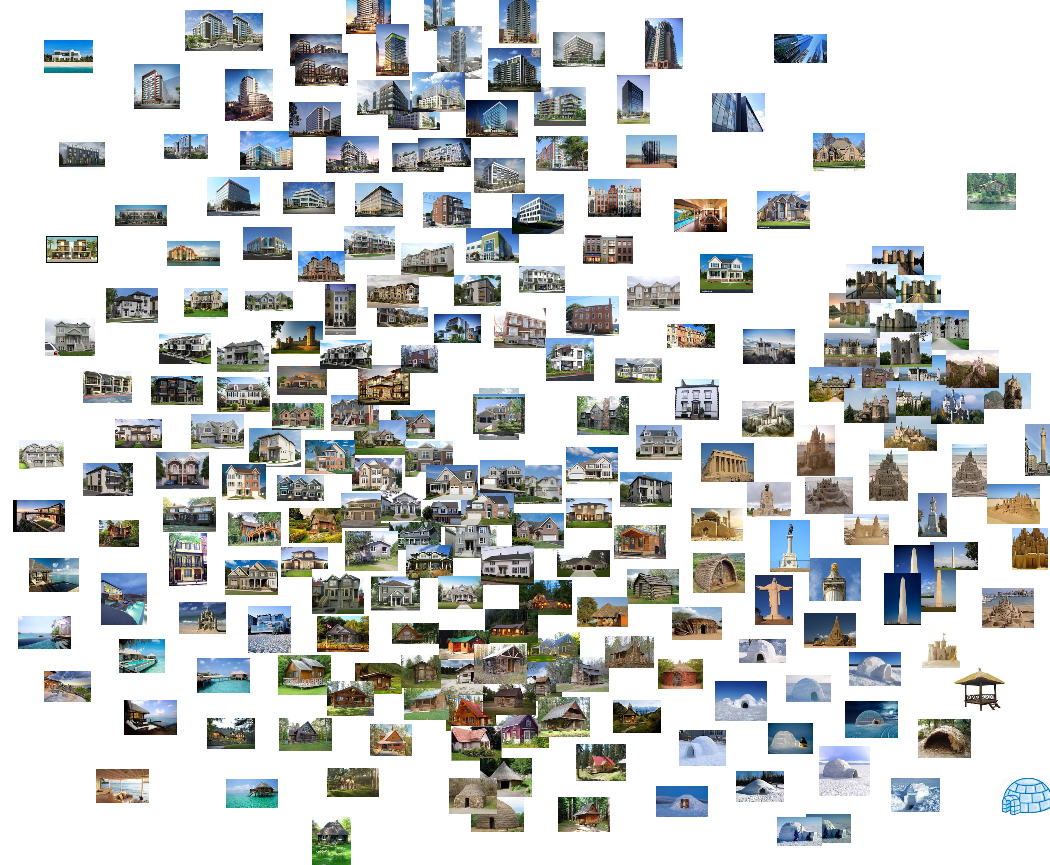

In [8]:
image_prefix = "http://public.mldb.ai/datasets/dataset-builder/images/realestate_png/"

df = mldb.query("SELECT * from tsne_embedding")
bounds = df.quantile([.05, .95]).T.values
fig = plt.figure(figsize=(18, 15), frameon=False)
ax = fig.add_subplot(111, xlim=bounds[0], ylim=bounds[1])
plt.axis('off')

for x in df.iterrows():
    imagebox = OffsetImage(read_png(urllib2.urlopen(image_prefix + "%s.png" % x[0])), zoom=0.35)
    ax.add_artist(AnnotationBbox(imagebox, xy=(x[1]["x"], x[1]["y"]), xycoords='data', frameon=False))

We can clearly see clusters of similar images in the scatter plot above. Most of the work to make this possible was already done, when the convolutional network was trained. This allowed a simple dimensionality reduction algorithm to get decent results.

## Supervised learning <a name="supervised"></a>

The second transfer learning task we will do is to use the image embeddings as features for a supervised multi-class classifier. In this example, we will train a bagged boosted decision tree to do multi-class classification on a subset of the labels present in the real-estate dataset used in the *unsupervised learning* example.

The following call will generate our training dataset, keeping only the images that are either a castle, an igloo, a cabin, a town house, a condo or a sand castle:


In [9]:
print mldb.put("/v1/procedures/<id>", {
    "type": "transform",
    "params": {
        "inputData": """
            SELECT *, regex_replace(rowName(), '-[\\d]+', '') as category
            FROM embedded_images_realestate
            WHERE regex_replace(rowName(), '-[\\d]+', '') IN 
                        ('castle', 'igloo', 'cabin', 'town_house', 'condo', 'sand_castle')
        """,
        "outputDataset": "training_dataset",
        "runOnCreation": True
    }
})

<Response [201]>


We can now take look at the generated dataset:

In [10]:
mldb.query("select * from training_dataset limit 3")

,category,"""pool_3.0.0.0.0""","""pool_3.0.0.0.1000""","""pool_3.0.0.0.1001""","""pool_3.0.0.0.1002""","""pool_3.0.0.0.1003""","""pool_3.0.0.0.1004""","""pool_3.0.0.0.1005""","""pool_3.0.0.0.1006""","""pool_3.0.0.0.1007""",...,"""pool_3.0.0.0.992""","""pool_3.0.0.0.993""","""pool_3.0.0.0.994""","""pool_3.0.0.0.995""","""pool_3.0.0.0.996""","""pool_3.0.0.0.997""","""pool_3.0.0.0.998""","""pool_3.0.0.0.999""","""pool_3.0.0.0.99""","""pool_3.0.0.0.9"""
_rowName,,,,,,,,,,,,,,,,,,,,,
igloo-5,igloo,0.482636,0.163070,0.153220,0.171316,0.385095,0.258053,0.305900,0.369143,0.102074,...,0.464035,0.268729,1.055752,0.423584,0.623712,0.337414,0.198597,0.116216,0.017429,0.183894
castle-19,castle,0.010620,0.728947,0.009469,0.089110,0.387459,0.177404,0.023197,1.259428,0.079046,...,0.040693,0.006199,1.264174,0.276042,0.103060,0.023312,0.089830,0.041281,0.121414,0.056849
cabin-9,cabin,0.006868,0.197314,0.059020,0.056589,0.114646,0.034227,0.104352,0.300197,0.198333,...,0.500429,0.101402,0.005117,0.465223,0.296787,0.290608,0.246980,0.476527,0.014312,0.027652


We can now use a procedure of type [`classifier.experiment`](../../../../doc/#builtin/procedures/ExperimentProcedure.md.html) to train and test our classifier. We will be using 2/3 of our data for training and the rest for testing:

In [13]:
rez = mldb.put("/v1/procedures/<id>", {
    "type": "classifier.experiment",
    "params": {
        "experimentName": "realestate",
        "inputData": """        
            SELECT 
                {* EXCLUDING(category)} as features,
                category as label
            FROM training_dataset
        """,
        "datasetFolds": [
                {
                    "trainingWhere": "rowHash() % 3 < 2",
                    "testingWhere": "rowHash() % 3 = 2",
                }
            ],
        "modelFileUrlPattern": "file:///mldb_data/realestate.cls",
        "algorithm": "bbdt",
        "mode": "categorical",
        "outputAccuracyDataset": True,
        "runOnCreation": True
    }
})

runResults = rez.json()["status"]["firstRun"]["status"]["folds"][0]["resultsTest"]
print rez

<Response [201]>


We can now look at the average classification accuracy for all labels:

In [14]:
pd.DataFrame.from_dict({"weightedStatistics": runResults["weightedStatistics"]})

,weightedStatistics
f,1.003175
precision,1.013889
recall,1.000000
support,33.000000


Those results are pretty good, and again this shows how good the features we are getting from the ConvNet are.

We can look at the confusion matrix to give us a better idea of where the mistakes were made:

In [15]:
pd.DataFrame(runResults["confusionMatrix"]).pivot_table(index="actual", columns="predicted", fill_value=0)

count                                          
predicted   cabin castle condo igloo sand_castle town_house
actual                                                     
cabin           6      0     0     0           0          0
castle          0      4     0     0           0          0
condo           0      0     5     0           0          0
igloo           0      0     0     4           0          0
sand_castle     0      0     0     0           7          0
town_house      0      0     0     0           0          7

## The *Dataset Builder* plugin<a name="datasetBuilder"></a>

The *Dataset Builder* is a concrete example of the powerful things we can do with transfer learning. It essentially does similarity search to allow a user to very quickly build a binary image classifier by doing a combination of thow things: 

- nearest neighbour search by computing the distance between the embeddings of different images
- supervised classifier training using the embeddings as features

You can see the plugin in action in the video [included at the top of the notebook](#video).

### Installing the plugin

To play with the plugin yourself, you can install it in your MLDB instance by simply running the next cell:

In [16]:
print mldb.put('/v1/plugins/dataset-builder', {
    "type": "python",
    "params": {
        "address": "git://github.com/mldbai/dataset-builder.git"
    }
})

<Response [201]>


If you did not change the name of the plugin in the cell above, you can <a href="../../../../v1/plugins/dataset-builder/routes/static/index.html" target="_blank">load the plugin's UI here</a>.

NOTE: this only works if you're running this Notebook live, not if you're looking at a static copy on http://docs.mldb.ai. See the documentation for [Running MLDB](../../../../doc/#builtin/Running.md.html).

## See also

- [CNN Features off-the-shelf: an Astounding Baseline for Recognition](http://arxiv.org/abs/1403.6382)
- [How transferable are features in deep neural networks?](http://arxiv.org/abs/1411.1792)